In [20]:
#Import libraries
import requests
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.4.1


In [21]:
GRAIN_TYPE = 'Wheat'
FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + 'classifyVariety.h5'
URL = "../../Datasets/processed/" + GRAIN_TYPE + ".csv"
df = pd.read_csv(URL)
# Convert to numpy array
df = df.groupby('Variety').head(120)
df_features = df[[ 
                    'Freq', 
                    'd(cm)', 
                    'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    ]]

df_targets = df[['Variety']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
scaler = StandardScaler()
dataset_x = scaler.fit_transform(dataset_x)
dataset_y = df_targets.to_numpy()

In [22]:
from sklearn.preprocessing import LabelEncoder

# Getting the number of unique varieties
num_varieties = df_targets['Variety'].nunique()
varieties = df_targets['Variety'].unique()
print(f'There are {num_varieties} different varieties.')

# Encode the 'variety' labels
label_encoder = LabelEncoder()
# Step 1: Convert varieties into number ex. 1 2 3... and store in a single list
integer_encoded = label_encoder.fit_transform(df_targets['Variety'])
# Step 2: Get the number of different classes
depth = num_varieties
# Step 3: Pass in the list of numerical values and the number of classes and vectors are created 
#         For example the value 4 would be passed and converted to [0. 0. 0. 0. 1.]
one_hot_encoded = tf.one_hot(integer_encoded, depth)
# Step 4: Convert to numpy arr
y_one_hot = one_hot_encoded.numpy()  # If using TensorFlow's one_hot


There are 5 different varieties.


In [23]:
# Convert the one-hot encoded labels back to integer encoded labels for stratification
y_integers = np.argmax(y_one_hot, axis=1)

# Perform stratified train-test split on the data
X_trainVal, X_test, y_trainVal_integer, y_test_integer = train_test_split(
    dataset_x, y_integers, test_size=0.20, stratify=y_integers, random_state=42
)

# Convert the integer labels back to one-hot encoding for TensorFlow/Keras
y_trainVal = tf.one_hot(y_trainVal_integer, depth).numpy()
y_test = tf.one_hot(y_test_integer, depth).numpy()

# Stratified split for the validation set
X_train, X_val, y_train_integer, y_val_integer = train_test_split(
    X_trainVal, y_trainVal_integer, test_size=0.15, stratify=y_trainVal_integer, random_state=42
)

# Convert the integer labels back to one-hot encoding for TensorFlow/Keras
y_train = tf.one_hot(y_train_integer, depth).numpy()
y_val = tf.one_hot(y_val_integer, depth).numpy()


In [24]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from hyperopt import space_eval

# Define the search space
space = {
    'num_layers': hp.choice('num_layers', [2, 3, 4, 5]),
    'units_layer': hp.choice('units_layer', [64, 128, 256, 300,400,512]),
    'batch_size': hp.choice('batch_size', [8,16, 32, 64, 128]),
    'epochs': hp.quniform('epochs', 150, 800, 50),  # Range of epochs from 150 to 800 with steps of 50
    'learning_rate': hp.loguniform('learning_rate', -5, -2)
}

# Define the objective function
def objective(params):
    model = Sequential()
    model.add(Dense(int(params['units_layer']), activation='relu'))
    for _ in range(int(params['num_layers']) - 1):
        model.add(Dense(int(params['units_layer']), activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, 
                        epochs=int(params['epochs']),
                        batch_size=int(params['batch_size']),
                        validation_data=(X_val, y_val),
                        verbose=0)
    
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = np.max(history.history['val_accuracy'])
    return {'loss': -best_val_acc, 'params': params, 'status': STATUS_OK, 'best_epoch': best_epoch}

# Run the hyperparameter search using the tpe algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=4500,
            trials=trials)

# Extract the best hyperparameters
best_params = space_eval(space, best)
print('Best parameters:', best_params)

# Train and save the best model
best_model = Sequential()
best_model.add(Dense(best_params['units_layer'], activation='relu'))
for _ in range(best_params['num_layers'] - 1):
    best_model.add(Dense(best_params['units_layer'], activation='relu'))
best_model.add(Dense(5, activation='softmax'))

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

history = best_model.fit(X_train, y_train,
               epochs=int(best_params['epochs']),
               batch_size=int(best_params['batch_size']),
               validation_data=(X_val, y_val),
               verbose=1)

best_model.save("bestClassificationModelBAYES")


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [02:08<00:00, 12.83s/trial, best loss: -0.9444444179534912]
Best parameters: {'batch_size': 128, 'epochs': 600.0, 'learning_rate': 0.010299286103665636, 'num_layers': 5, 'units_layer': 64}
Epoch 1/600
4/4 [==============================] - 0s 18ms/step - loss: 1.6212 - accuracy: 0.2475 - val_loss: 1.4266 - val_accuracy: 0.3750
Epoch 2/600
4/4 [==============================] - 0s 4ms/step - loss: 1.3504 - accuracy: 0.4216 - val_loss: 1.2862 - val_accuracy: 0.4306
Epoch 3/600
4/4 [==============================] - 0s 4ms/step - loss: 1.1809 - accuracy: 0.4382 - val_loss: 0.9707 - val_accuracy: 0.5694
Epoch 4/600
4/4 [==============================] - 0s 4ms/step - loss: 0.9788 - accuracy: 0.5535 - val_loss: 0.9124 - val_accuracy: 0.5556
Epoch 5/600
4/4 [==============================] - 0s 4ms/step - loss: 0.9124 - accuracy: 0.6209 - val_loss: 0.9082 - val_accuracy: 0.5694
Epoch 6/600
4/4 [==============================] - 0s 4ms/step - loss: 0.8833 - accuracy: 0.

2024-03-03 19:31:14.577100: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: bestClassificationModelBAYES/assets


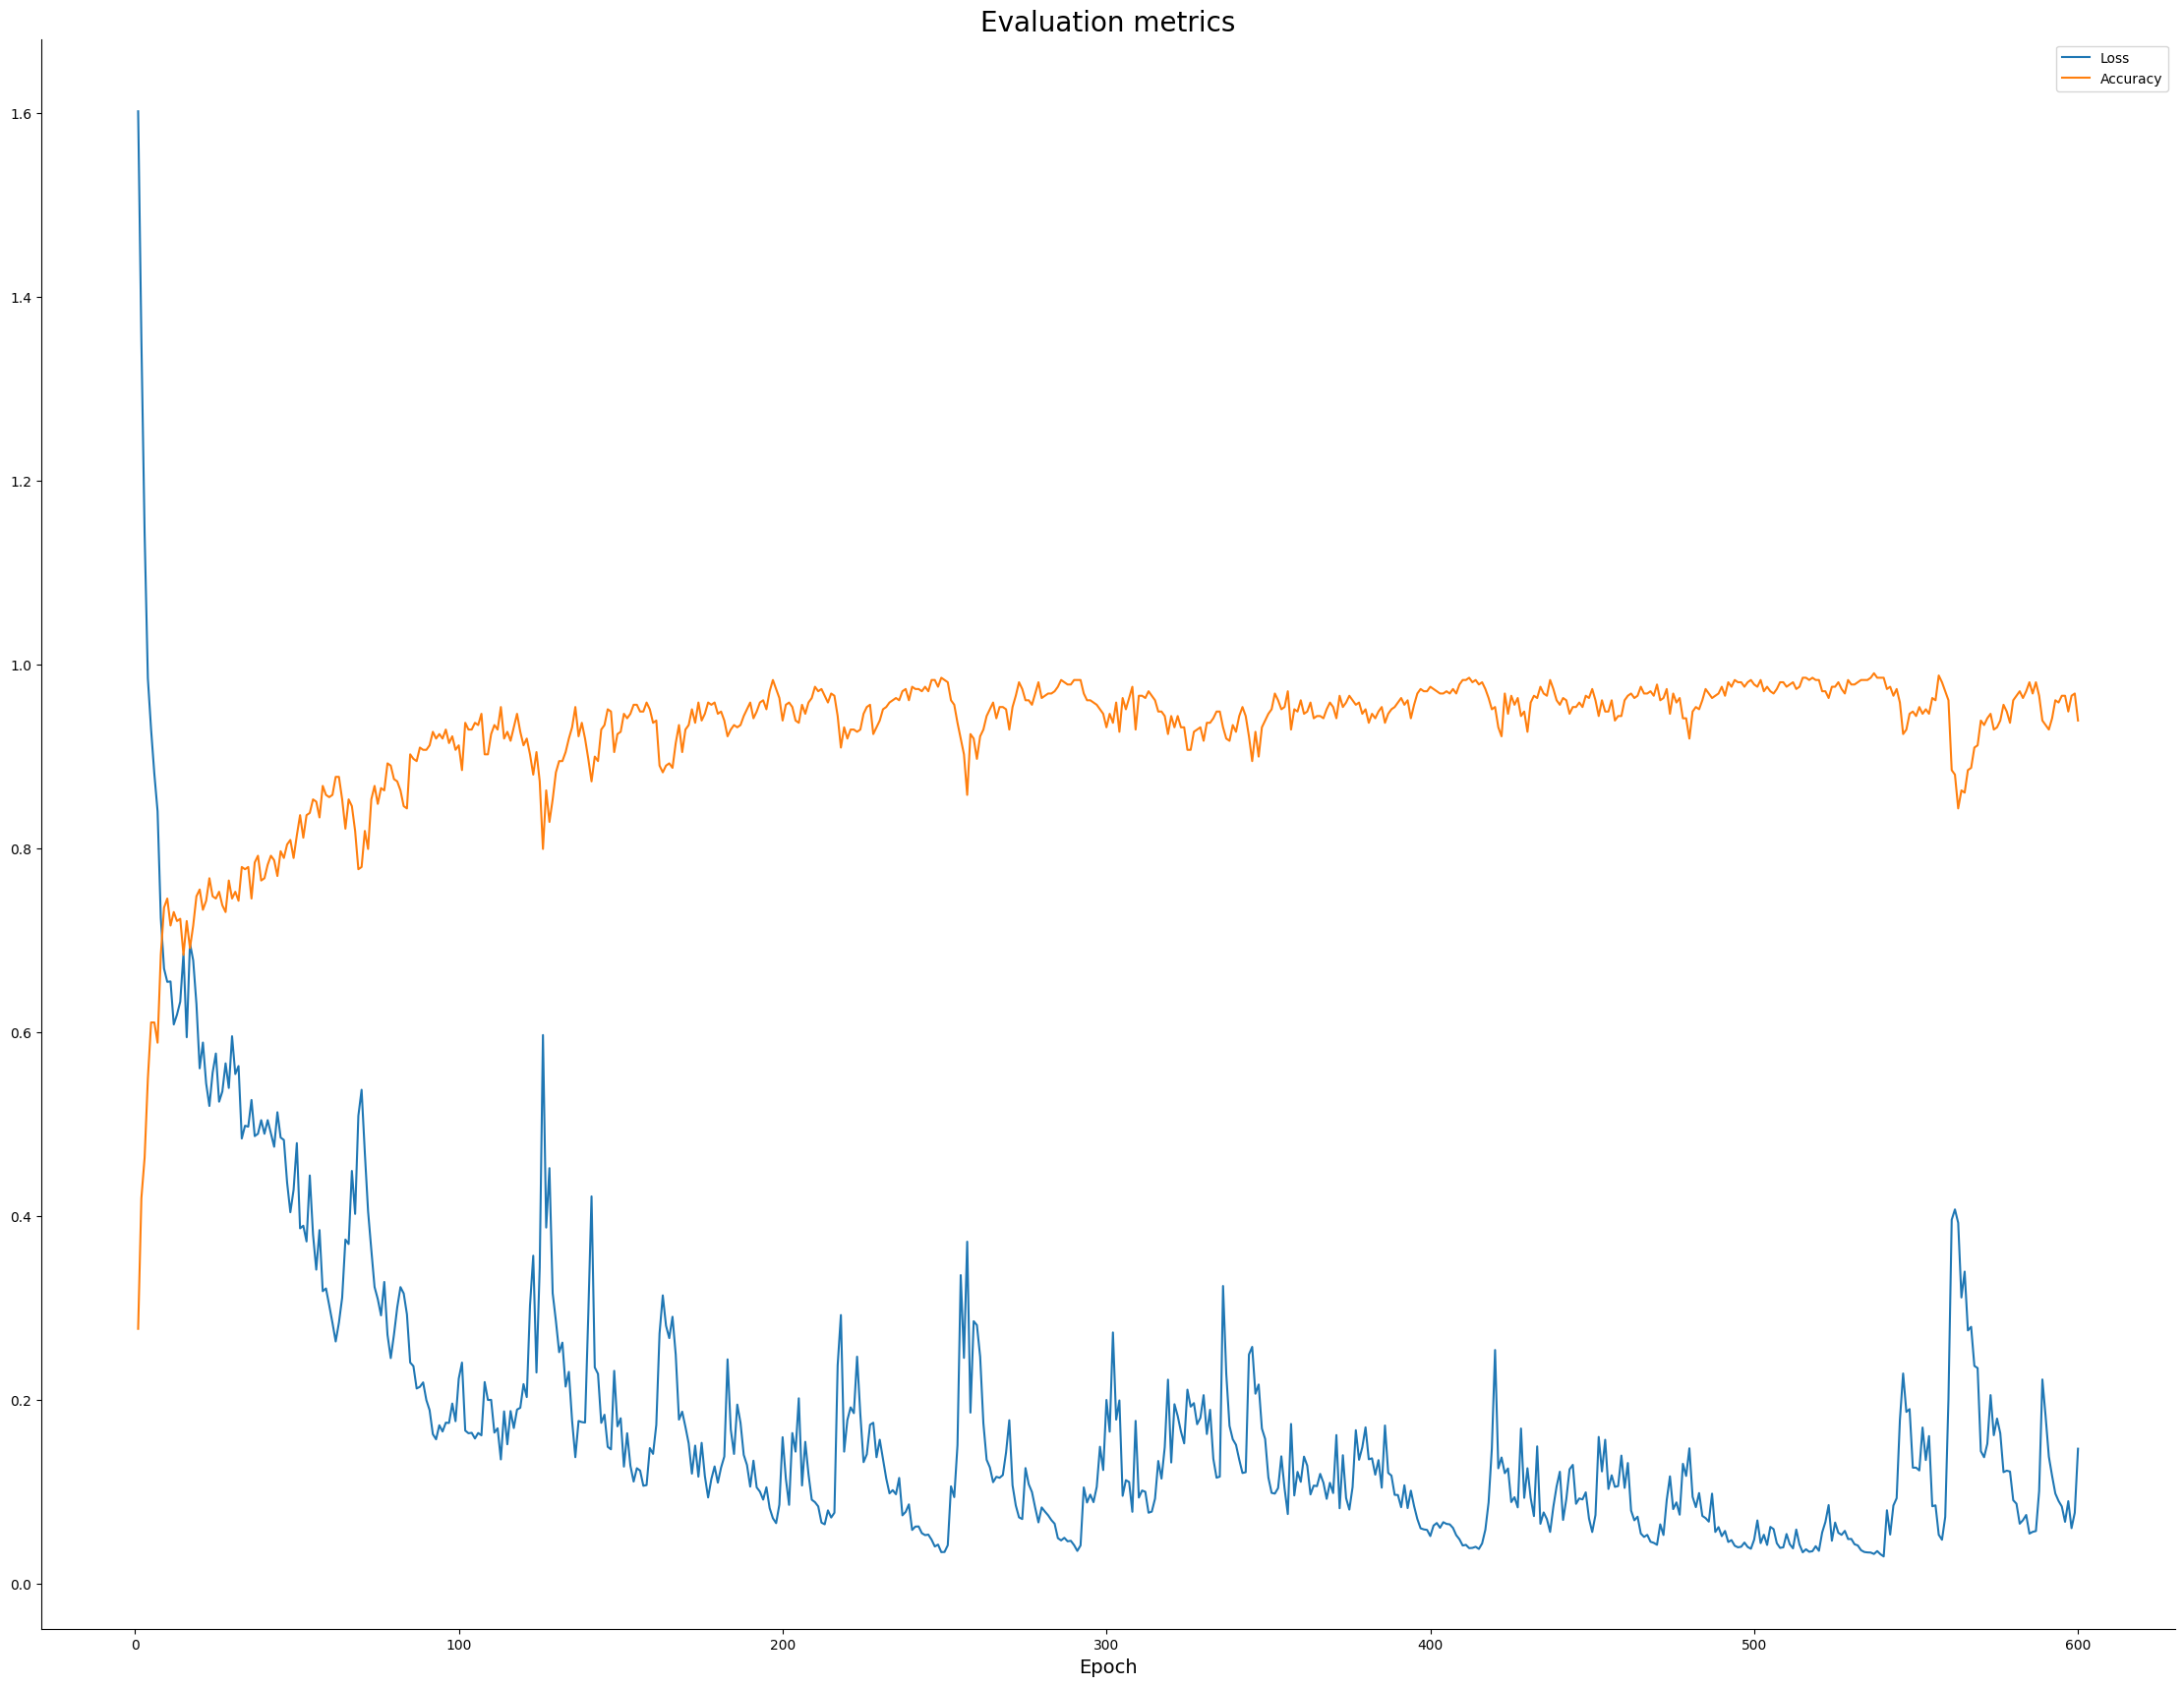

In [25]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
trial_timeout=30
rcParams['figure.figsize'] = (28, 21)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

# Correcting the range of epochs to match the actual number of epochs trained
epochs_trained = len(history.history['loss']) 

# Plot Loss and Accuracy
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['accuracy'], label='Accuracy'
)

# Plot Precision and Recall for each class
num_classes = 5  # Update this with the actual number of classes you have
for i in range(num_classes):
    precision_label = f'precision_class_{i}'
    recall_label = f'recall_class_{i}'
    
    # Check if precision and recall for each class are in history to avoid KeyError
    if precision_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[precision_label], label=f'Precision Class {i}'
        )
    if recall_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[recall_label], label=f'Recall Class {i}'
        )

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.show()


In [29]:
# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

# Initialize dictionary to hold the metrics
metrics_per_class = {
    'Loss': test_loss,
    'Accuracy': test_accuracy,
}

# Calculate per-class precision and recall
predictions = best_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import precision_score, recall_score

num_classes = 5  # Update this with the actual number of classes you have
for i in range(num_classes):
    # Calculate precision and recall for class i
    precision = precision_score(y_true, y_pred, labels=[i], average=None)
    recall = recall_score(y_true, y_pred, labels=[i], average=None)
    metrics_per_class[f'Precision Class {i}'] = precision[0]  # Precision for class i
    metrics_per_class[f'Recall Class {i}'] = recall[0]  # Recall for class i

# Display the metrics for each class
for metric_name, metric_value in metrics_per_class.items():
    print(f'{metric_name}: {metric_value:.4f}')


4/4 [==============================] - 0s 371us/step - loss: 0.2337 - accuracy: 0.9250


Loss: 0.2337
Accuracy: 0.9250
Precision Class 0: 0.8750
Recall Class 0: 0.8750
Precision Class 1: 0.9583
Recall Class 1: 0.9583
Precision Class 2: 0.8800
Recall Class 2: 0.9167
Precision Class 3: 1.0000
Recall Class 3: 0.9583
Precision Class 4: 0.9167
Recall Class 4: 0.9167
